Adapted from [https://github.com/PacktPublishing/Bioinformatics-with-Python-Cookbook-Second-Edition](https://github.com/PacktPublishing/Bioinformatics-with-Python-Cookbook-Second-Edition), Chapter 3.

First, get the genome of *P. falciparum* from [https://plasmodb.org/common/downloads/Current_Release/Pfalciparum3D7/fasta/data/](https://plasmodb.org/common/downloads/Current_Release/Pfalciparum3D7/fasta/data/). You can find a copy in `files/PlasmoDB-46_Pfalciparum3D7_Genome.fasta`

In [5]:
!rm -f files/PlasmoDB-46_Pfalciparum3D7_Genome.fasta 2>/dev/null
!wget http://plasmodb.org/common/downloads/Current_Release/Pfalciparum3D7/fasta/data/PlasmoDB-46_Pfalciparum3D7_Genome.fasta
!mv PlasmoDB-46_Pfalciparum3D7_Genome.fasta files    

--2020-02-26 17:53:27--  http://plasmodb.org/common/downloads/Current_Release/Pfalciparum3D7/fasta/data/PlasmoDB-46_Pfalciparum3D7_Genome.fasta
Resolving plasmodb.org... 128.192.75.73
Connecting to plasmodb.org|128.192.75.73|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://plasmodb.org/common/downloads/Current_Release/Pfalciparum3D7/fasta/data/PlasmoDB-46_Pfalciparum3D7_Genome.fasta [following]
--2020-02-26 17:53:27--  https://plasmodb.org/common/downloads/Current_Release/Pfalciparum3D7/fasta/data/PlasmoDB-46_Pfalciparum3D7_Genome.fasta
Connecting to plasmodb.org|128.192.75.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23723408 (23M) [application/x-fasta]
Saving to: 'PlasmoDB-46_Pfalciparum3D7_Genome.fasta'

PlasmoDB-46_Pfalcip 100%[===================>]  22.62M  3.30MB/s    in 15s     

2020-02-26 17:53:43 (1.46 MB/s) - 'PlasmoDB-46_Pfalciparum3D7_Genome.fasta' saved [23723408/23723408]



In [6]:
from Bio import SeqIO
genome_name = 'files/PlasmoDB-46_Pfalciparum3D7_Genome.fasta'
recs=SeqIO.parse(genome_name,'fasta')
for rec in recs:
    print(rec.description)

Pf3D7_01_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=640851 | SO=chromosome
Pf3D7_02_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=947102 | SO=chromosome
Pf3D7_03_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1067971 | SO=chromosome
Pf3D7_04_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1200490 | SO=chromosome
Pf3D7_05_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1343557 | SO=chromosome
Pf3D7_06_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1418242 | SO=chromosome
Pf3D7_07_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1445207 | SO=chromosome
Pf3D7_08_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1472805 | SO=chromosome
Pf3D7_09_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | length=1541735 | SO=chromosome
Pf3D7_10_v3 | organism=Plasmodium_falciparum_3D7 | version=2015-06-18 | len

In [7]:
from Bio import SeqUtils

chrom_sizes = {}
chrom_GC = {}
recs = SeqIO.parse(genome_name, 'fasta')
block_size = 50000
min_GC = 100.0
max_GC = 0.0
for rec in recs:
    if rec.description.find('SO=chromosome') == -1:
        continue
    chrom = int(rec.description.split('_')[1])
    chrom_GC[chrom] = []
    size = len(rec.seq)
    chrom_sizes[chrom] = size
    num_blocks = size // block_size + 1
    for block in range(num_blocks):
        start = block_size * block
        if block == num_blocks - 1:
            end = size
        else:
            end = block_size + start + 1
        block_seq = rec.seq[start:end]
        block_GC = SeqUtils.GC(block_seq)
        if block_GC < min_GC:
            min_GC = block_GC
        if block_GC > max_GC:
            max_GC = block_GC
        chrom_GC[chrom].append(block_GC)
print(min_GC, max_GC)

16.14167716645667 43.673469387755105


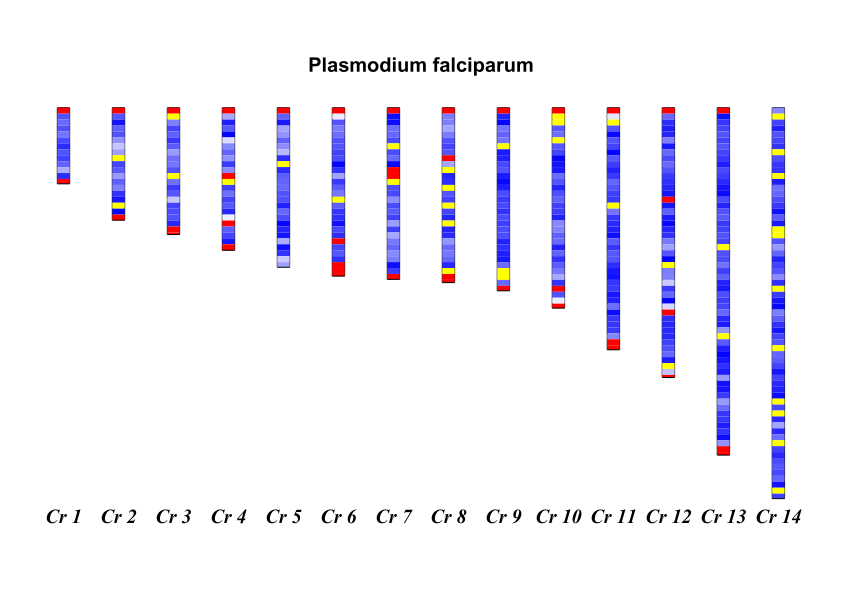

In [10]:
from IPython.core.display import Image
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import BasicChromosome
chroms = list(chrom_sizes.keys())
chroms.sort()

biggest_chrom = max(chrom_sizes.values())

my_genome = BasicChromosome.Organism(output_format="png")

my_genome.page_size = (29.7*cm, 21*cm) # check
telomere_length = 10

bottom_GC = 17.5
top_GC = 22.0
for chrom in chroms:
    chrom_size = chrom_sizes[chrom]
    chrom_representation = BasicChromosome.Chromosome('Cr %d' % chrom)
    chrom_representation.scale_num = biggest_chrom

    tel = BasicChromosome.TelomereSegment()
    tel.scale = telomere_length
    chrom_representation.add(tel)

    num_blocks = len(chrom_GC[chrom])
    for block, gc in enumerate(chrom_GC[chrom]):
        my_GC = chrom_GC[chrom][block]
        body = BasicChromosome.ChromosomeSegment()
        if my_GC > top_GC:
            body.fill_color = colors.Color(1, 0, 0)
        elif my_GC < bottom_GC:
            body.fill_color = colors.Color(1, 1, 0)
        else:
            my_color = (my_GC - bottom_GC) / (top_GC - bottom_GC)
            body.fill_color = colors.Color(my_color, my_color, 1)
        if block < num_blocks - 1:
            body.scale = block_size
        else:
            body.scale = chrom_size % block_size
        chrom_representation.add(body)

    tel = BasicChromosome.TelomereSegment(inverted=True)
    tel.scale = telomere_length
    chrom_representation.add(tel)

    my_genome.add(chrom_representation)

my_genome.draw("figures/falciparum.png", "Plasmodium falciparum")
Image("figures/falciparum.png")